In [2]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

ponifile = "../PROCESSED_DATA/LAB6_calib_scan4.poni"


## Load masks

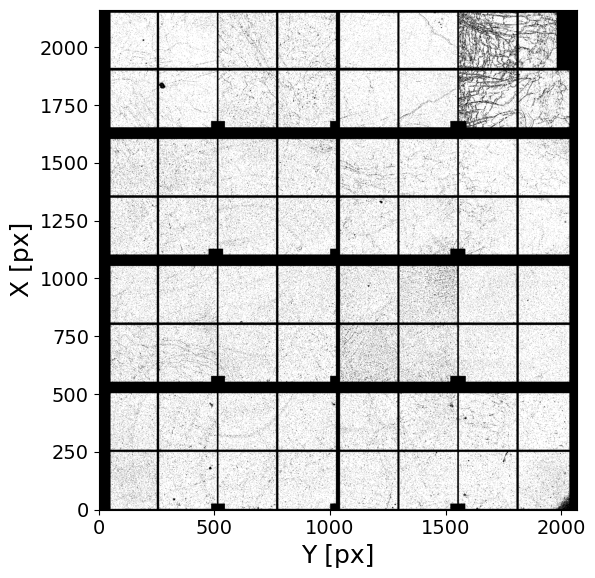

In [3]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

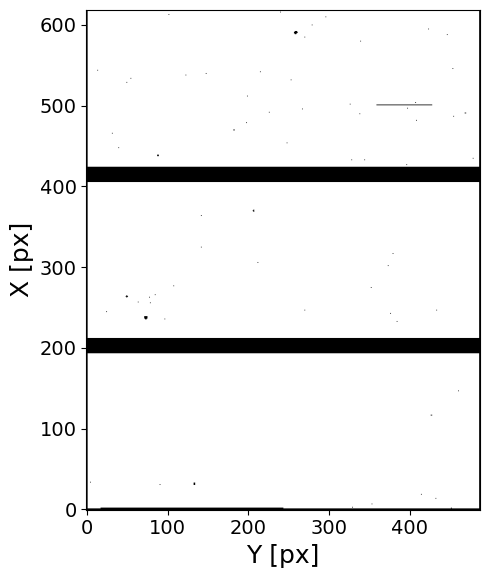

In [4]:
pilatus_mask = ~np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow(pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [4]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 3
Nfi, Nff = 0, 80_000
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
theta = 10.0
Qc = 1.91
#############################



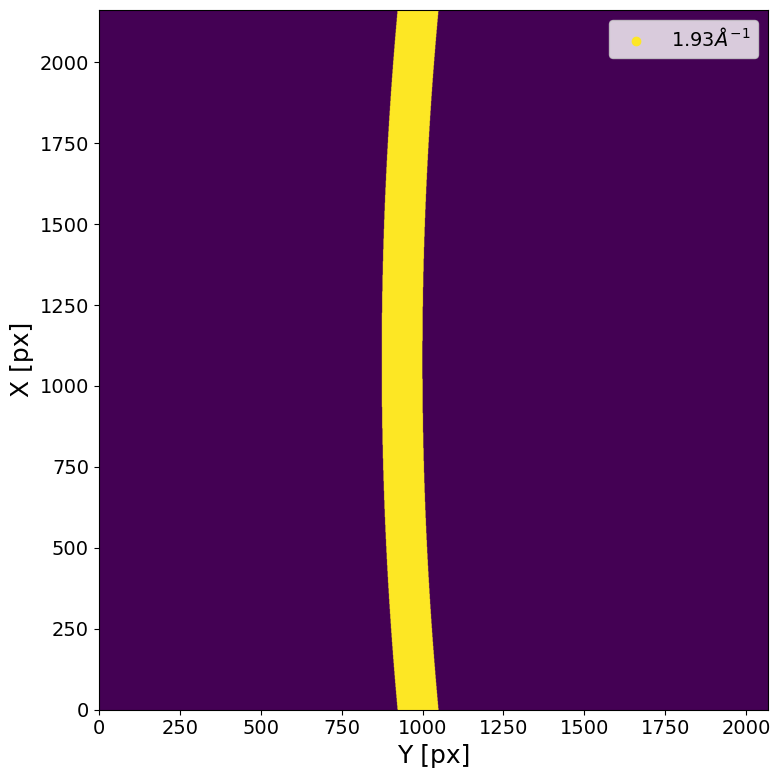

In [5]:
###########
dq = 0.01
###########

#Qmask = XPCS.gen_Qmask(Ei, theta, Qc+np.array([-1,0,1])*2*dq, dq, Qmap_plot=False)
Qmask = XPCS.gen_Qmask(Ei, theta, 1.93, dq, Qmap_plot=False)

## XPCS scan: delcoup=10, T=12h (Ta2O5_2.5um, 2, 4)
Super long scan for the hull night and more

In [5]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
load_mask = None #e4m_mask*e4m_htmask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

##########################################################
Nfi, Nff = None, int(1e6)#scan['fast_timer_period'].size-5001
##########################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )
#e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
T =  15.707186611111112 h
theta = 10.0
Qc = 1.91
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00022.h5 (23/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00027.h5 (28/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00018.h5 (19/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/201 loops)
	 -> loading file	 -> loading file eiger4m_v2_sparse_frame_0_00019.h5 (20/201 loops)
 eiger4m_v2_sparse_frame_0_00020.h5 (21/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00017.h5 (18/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_0

: 

### Intensity

In [7]:
####################
Lbin = 1
Nstep = 100
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)

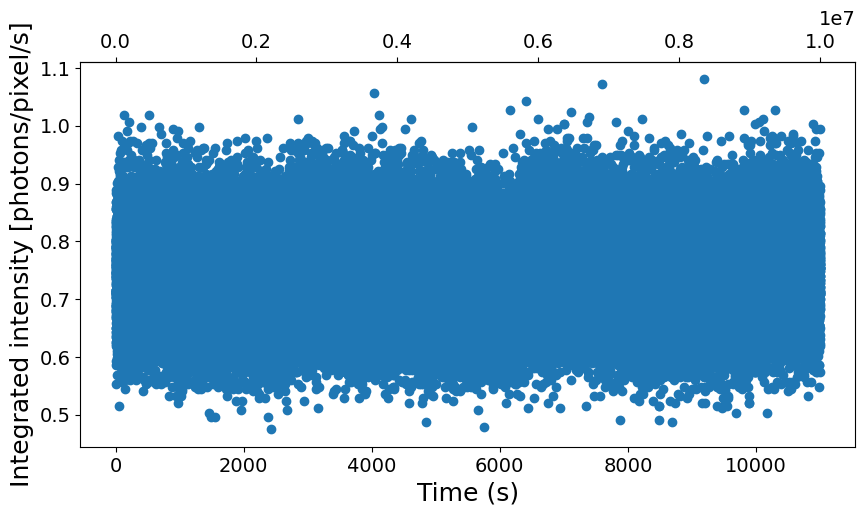

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.ylim(0)
#plt.xscale('log') 
#plt.xlim(16000, 17500)
plt.show()

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  4248917 pixels (of 4471016 => 95.03 %)
# of pixels below Ith_low treshold ->  11 pixels (of 4471016 => 0.0 %)
################################################################################



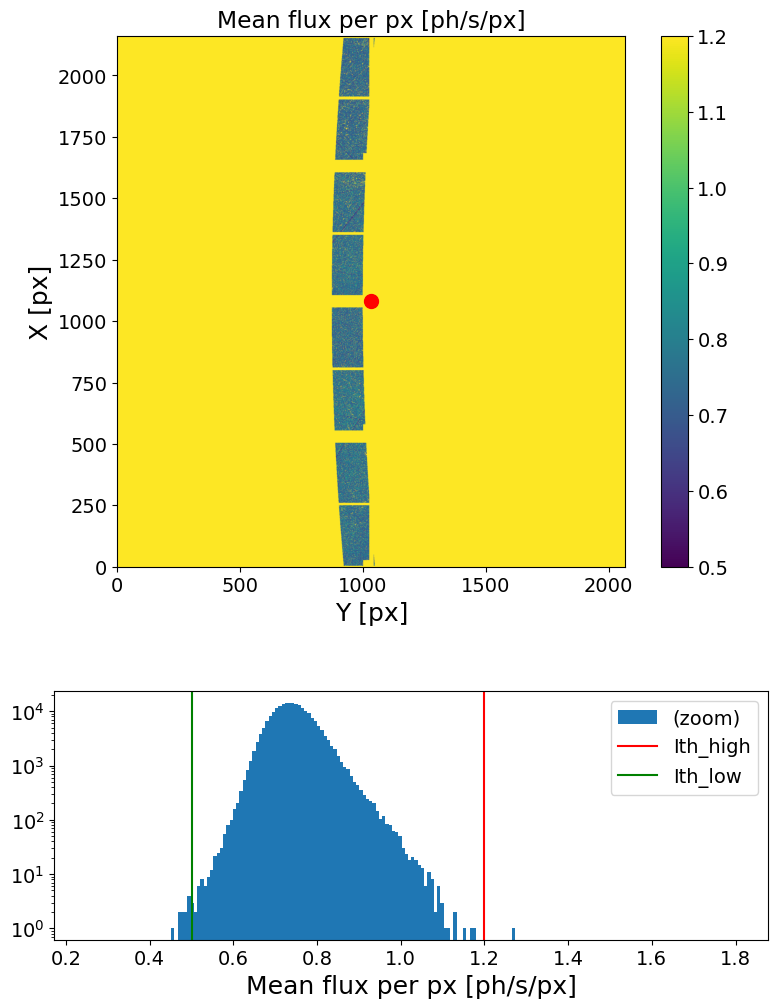

In [ ]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.5, Ith_high=1.2, Nfi=None, Nff=int(1e7), mask=None)

In [18]:
Kossel_mask = XPCS.gen_mask(e4m_data, itime, Ith_low=.5, Nfi=None, Nff=None, mask=None,)

ValueError: Cannot generate a mask from already masked data!

In [ ]:
np.save(MASKS_folder  + 'Kossel_mask_Ta2O5_2.5um_0002_0004.npy', Kossel_mask)